In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem
from rdkit.Chem import AllChem

from utils import get_statisicts
from utils import pearson_confidence
from utils import max_possible_correlation
from utils import cluster_fps
from utils import get_data
from utils import get_sim_data

sns.set()

## Model trainig, cross-validation and evaluations

Models description:      
1. `ESOLCalculator`:    
2. `RFRegressor`:   
3. `NfpRegressor`:
4. `EnsembleReressor`



Each model is trained and validated using 5 cross-fold validation (by default). Calculated statistics are: Mean square error (mse), Mean absolute error (mae), and Pearson's $R^2$. The results are saved in the file format:       
`MODEL_NAME (STATISTIC_MEAN STATISTIC_STD)`      

The training set consist of a set of 1865 for `solubility.uniq.no-in-100.smi` (or 1912 for `solubility.uniq.no-in-32.smi`) compounds with measured $\rm{log}S_0$. Each of this two datasets contain unique compounds and all the compounds from Test Set 1 (TS-1) and Test Set 2 (TS-2) are exluded from the training set.  

The results below are for 4 models: ESOL, Random Forest (RF), Neural Fingerprint (Nfp), and Ensemble methods. 
For a comparision I also added a data from the [putatively](https://github.com/pgniewko/solubility/blob/master/src/notebooks/assets/mpnn.moleculenet.png) best model (MPNN) that I found at [MoleculeNet website](http://moleculenet.ai/). Because standard errors (or confidence intervals) are not provided, for the plotting purposes we set them to 0.

Text(0, 0.5, "Theoreticlly max. value of Pearson's R**2")

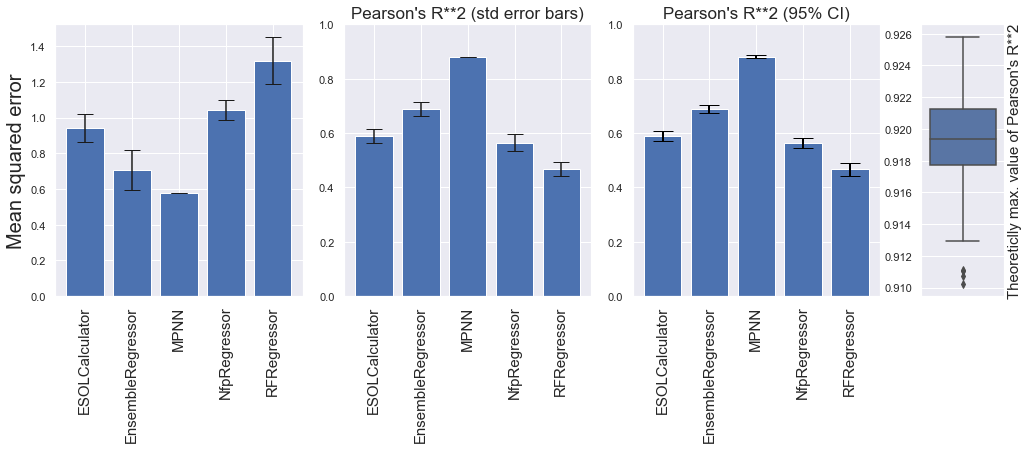

In [2]:
#The code below reads the data saved at the end of the trainig and validation, analyses and plots the results.

CURRENT_PATH = os.getcwd()
RESULTS_PATH = '{}/../../results'.format(CURRENT_PATH)

models_data_files = ['esol-no-in-100.dat',
                     'rf-no-in-100.dat',
                     'nfp-no-in-100.dat',
                     'ensemble-no-in-100.dat',
                     'mpnn.delaney.dat']

statistics_map = {'mse':0, 'mae':1, 'pearsonr':2}


# Read logS0 values used for training and cross-validation
logS0 = []
logS0_FILE = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
with open(logS0_FILE, 'r') as fin:
    for line in fin:
        pairs = line.rstrip('\n').split(',')
        logS0.append(float(pairs[1]))

num = len(logS0)

fig = plt.figure(figsize=(17,5))
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[3,3,3,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[0,3])
ax2.set_ylim([0,1])
ax3.set_ylim([0,1])

# Mean square error
models_mse = get_statisicts('mse', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_mse[key][0] for key in sorted(models_mse.keys())]
std = [models_mse[key][1] for key in sorted(models_mse.keys())]
ax1.bar(sorted(models_mse.keys()), vals, yerr=std,capsize=8)
ax1.set_xticklabels(sorted(models_mse.keys()), rotation=90, fontsize=15)
ax1.set_ylabel('Mean squared error', fontsize=20)

# Pearson's R
models_pearsonr = get_statisicts('pearsonr', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_pearsonr[key][0]**2.0 for key in sorted(models_pearsonr.keys())]
std = [models_pearsonr[key][1] for key in sorted(models_pearsonr.keys())]
ax2.bar(sorted(models_pearsonr.keys()), vals, yerr=std,capsize=8)
ax2.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax2.set_title('Pearson\'s R**2 (std error bars)', fontsize=17)

# Confidence intervals
lb = []
ub = []
for model in sorted(models_pearsonr.keys()):
    values = models_pearsonr[model]
    r = values[0]**0.5 # R^2 --> R
    rlower, rupper = pearson_confidence(r, num, interval=0.95)
    lb.append(r**2 - rlower**2) # In respect to R^2
    ub.append(rupper**2 - r**2) # In respect to R^2
    
ax3.bar(sorted(models_pearsonr.keys()), vals, yerr=None)
ax3.errorbar(sorted(models_pearsonr.keys()), vals, yerr=[lb,ub], fmt="none", capsize=10, elinewidth=2,color='black')
ax3.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax3.set_title('Pearson\'s R**2 (95% CI)', fontsize=17)

ax4.yaxis.set_label_position("right")
_, pr_corrs =  max_possible_correlation(logS0, error=0.6, cycles=500)
sns.boxplot(np.array(pr_corrs)**2.0, ax=ax4, orient='v')
ax4.set_ylabel('Theoreticlly max. value of Pearson\'s R**2', fontsize=15)

The first plot on the left provides average MSE values (and standard deviations calculated over 5 cross-folds). Among 4 trained models, `EnsembleRegressor` seems to be the best one, but it's outperformed b `MPNN` model. Surprisingly the perfomance of `MPNN` is belos $MSE \approx 0.6 \rm{log}~units$, which raises some concerns in the context of the [2019 challange data](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345), suggesting that the experimental accuracy is about `0.62`. When we look at the Pearson's $R^2$ coefficient, we can still see that `EnsembleRegressor` performs best (and that difference is rather statistically significant; confidence intervls calculated with this [code](https://github.com/pgniewko/solubility/blob/master/src/notebooks/utils.py)), but all this methods are out run by `MPNN`, with Pearson's $R^2$ reported to be 0.839. In addition, I checked the maximum possible Pearson's $\left<R^2\right>$ (as suggested [here](https://practicalcheminformatics.blogspot.com/2019/07/how-good-could-should-my-models-be.html)). I assumed that the standard error is $0.6 \rm{log}~units$ (following this [paper](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345)). This calculation suggests that the theoretically maximal value of $R^2$ is c.a. 0.919, and `MPNN`, is not only reaching, but even exceeding theoretical performance. In defense of `MPNN`, I shall mention that the model was trained and evaluated on the original Delaney dataset (about 1200 compounds), which by the way makes a majority of the training data in the above work.

# Models evaluation on Test Set1 and Test Set 2

The full data for the Test Set 1 and 2 is not available at the moment, but some of the compounds in the test sets have their $\rm{log}S_0$ values known. These compounds are excluded from the training set, and instead were used in a partial evaluation of the trained models.     

Below I provide a data for the partial performance of these modes. Ensemble regressor is best on TS-1, but interestingly it's performance is poor for TS-2. Random Forest model shows the similar behavior!. Interestinglty the most robust model seems to be the physics-based one: `ESOLCalculator`.

|Method| TEST SET 1 (100 compounds) | TEST SET 2 (32 compounds) |   
|------|------------|------------|
|ESOL| 0.878 | 1.072 |
|RF| 0.877 | 1.921 |
|Nfp| 1.348 | 2.632 |
|Ensemble| 0.738 | 1.447 |
|GSE*| 0.826 | 1.144 |
|GSE (total) | 1.12 | 1.19 |

Table: 60 compounds have measured $\rm{log}S_0$ in Test Set 1, and 13 compounds have measured $\rm{log}S_0$ in Test Set 2. GSE* is RMSE for the subset of this two datasets (60 and 13 respectively), and GSE (total) is RMSE [provided](https://github.com/pgniewko/solubility/blob/master/data/raw/LA.2019.JCIM.xlsx) for the whole datasets. RMSE for the trained models are calculated only over the Test Sets subsets.

From the (partial) results above (obtained with `estimate_accuracy.py` script), it's quite clear that, despite a good perfomance on the training set, the performance on the two independet datasets is noticably lower. In order to understand why the models don't generalized well, I plotted logS0 values for the training set and as a reference, $\rm{log}S_0$ values from the  General Solubility Equation ([GSE](https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html)).

In [3]:
def plot_data(fname, ax, label=''):
    vals = get_data(fname)
    sns.distplot(vals,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
                )

def plot_sims(tarining_fname, target_file, ax, nbins=40, label=''):
    mol_sims = get_sim_data(tarining_fname, target_file)
    sns.distplot(mol_sims,
                 bins=nbins,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
            )

def plot_sims(tarining_fname, target_file, ax, nbins=40, label=''):
    mol_sims = get_sim_data(tarining_fname, target_file)
    sns.distplot(mol_sims,
                 bins=nbins,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
            )

def plot_effective_size(fname, ax):
    smiles = []
    with open(fname, 'r') as fin:
        for line in fin:
            pairs = line.rstrip('\n').split(',')
            smiles.append(pairs[0])

    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024) for x in smiles]

    thrs = np.linspace(0.01, 0.99, 15)
    x = []
    y = []
    for _, thr in enumerate(thrs):
        clusts = cluster_fps(fps, cutoff=thr)
        x.append(1.0 - thr)
        y.append(len(clusts) / len(smiles))

    sns.lineplot(x, y, ax=ax, label='Training Set', lw=2)
    ax.plot([0.4, 0.4], [0, 1], '--', lw=2)
    #ax.lines[1].set_linestyle("--")

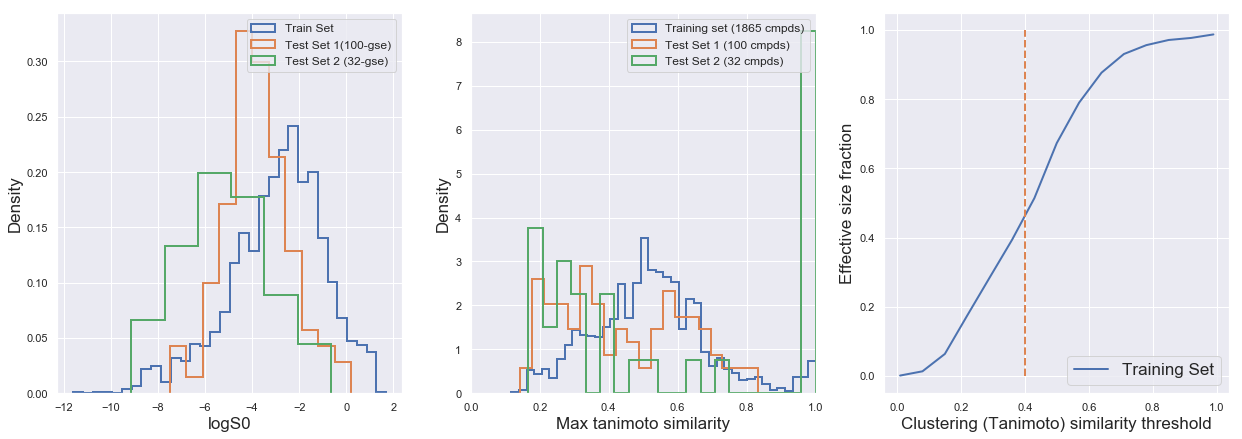

In [4]:
fig, axis = plt.subplots(1, 3, figsize=(21,7))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

ax2.set_xlim([0,1])

# Input files
training_set_file = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
f_100_gse = '{}/../../data/test/test_100.with.gse.smi'.format(CURRENT_PATH)
f_32_gse = '{}/../../data/test/test_32.with.gse.smi'.format(CURRENT_PATH)
set_100_smiles_file = '{}/../../data/test/test_100.smi'.format(CURRENT_PATH)
set_32_smiles_file = '{}/../../data/test/test_32.smi'.format(CURRENT_PATH)

# Subplot 1
plot_data(training_set_file, ax1, 'Train Set')
plot_data(f_100_gse, ax1, 'Test Set 1(100-gse)')
plot_data(f_32_gse, ax1, 'Test Set 2 (32-gse)')
ax1.set_xlabel("logS0", fontsize=17)
ax1.set_ylabel("Density", fontsize=17)
ax1.legend(fontsize=12)


# Subplot 2
plot_sims(training_set_file, training_set_file, ax2, nbins=40, label='Training set (1865 cmpds)')
plot_sims(training_set_file, set_100_smiles_file, ax2, nbins=20, label='Test Set 1 (100 cmpds)')
plot_sims(training_set_file, set_32_smiles_file, ax2, nbins=20, label='Test Set 2 (32 cmpds)')
ax2.set_xlabel("Max tanimoto similarity", fontsize=17)
ax2.set_ylabel("Density", fontsize=17)
ax2.legend(fontsize=12)


# Subplot 3
plot_effective_size(training_set_file, ax3)
ax3.set_xlabel("Clustering (Tanimoto) similarity threshold", fontsize=17)
ax3.set_ylabel("Effective size fraction", fontsize=17)
ax3.legend(fontsize=17)

The distributions above hint to the reason why the models perform poorly. As we can see the compounds in the train set, TS-1 and TS-2 are not drawn from the same distribution.As we can see, the mode of logS for the train set is around $mode(\rm{log}S_0)\approx -2$, wheres it's abut $mode(\rm{log}S_0)\approx -4$ for TS-1 and $mode(\rm{log}S_0)\approx -6$ for TS-2. This differences can't be completely explained by the inacrracy of GSE, as the [RMSE](https://github.com/pgniewko/solubility/blob/master/data/raw/LA.2019.JCIM.xlsx) for this model is of the order of $1 \rm{log}~unit$. Thus, the fact that the physico-chemical space for the two test sets overlap only partially with the physico-chemical space of the training set, suggests the poor generalization of the models; especially in Random Forest case.       

Finally it's important to mention that the amount of the trainig data is rather small, ~1900 datapoints. For such a small sample size, it's not surprising that the Deep Learning methods do not deliver expected performance, and perform on par with the classical ML methods.